In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cpu


In [2]:
BATCH_SIZE = 8

# Define the transformations to apply to the dataset 
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize(mean=[0], std=[1])
    ])    # Normalize the image

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Create a DataLoader to load the data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Create a DataLoader for the test data
testloader = torch.utils.data.DataLoader(testset, BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


# Define the classes in CIFAR-10
classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

val_loader = torch.utils.data.DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=2)


# Help Functions

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.act = nn.Tanh()

        # input: 32x32x1
        self.c1 = nn.Conv2d(1, 3, kernel_size=3, padding=1) # output: 32x32x3 SAME
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x3 

        self.c2 = nn.Conv2d(3, 6, kernel_size=3, padding=1) # output: 16x16x6 SAME
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x6 
        
        self.c3 = nn.Conv2d(6, 12, kernel_size=3, padding=1) # output: 8x8x12 SAME
        
        self.fc1 = nn.Linear(in_features=8*8*12, out_features=60) 

        self.fc2 = nn.Linear(in_features=60, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)


    
    def forward(self, x):
        #Conv Layer 1
        x = self.c1(x)
        x = self.act(x)
        x = self.pool1(x)
        
        #Conv Layer 2        
        x = self.c2(x)
        x = self.act(x)
        x = self.pool2(x)

        #Conv Layer 3
        x = self.c3(x)
        x = self.act(x)

        #Flattening
        x = torch.flatten(x, 1)

        #FC Layer 1
        x = self.fc1(x)
        x = self.act(x)

        #FC Layer 2
        x = self.fc2(x)       
        
        #Softmax
        out = self.logSoftmax(x)

        return out
    

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(epoch, "ANTON")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            if (batch_nr%300 == 0):
                print("batch_nr:",batch_nr," loss:",loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        writer.add_scalar("loss/train", train_loss, epoch)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    writer.add_scalar("loss/val", val_loss, epoch)
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    writer.flush()
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cpu
Test Loss: 0.0059, Test Accuracy: 98.42%
Confusion matrix, without normalization


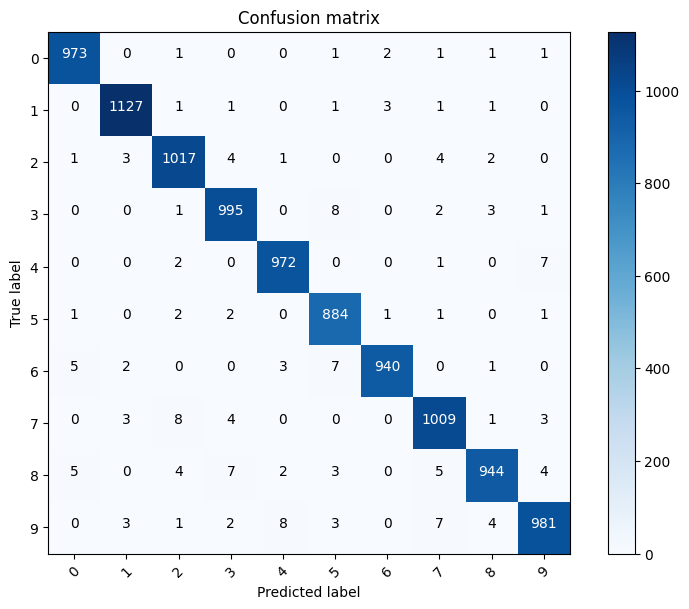

In [6]:
LEARNING_RATE = 0.0001
EPOCHS = 3

print(device)
model = CNN(num_classes=10).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
#trained_model = train_model(model, criterion, optimizer, trainloader, val_loader, EPOCHS)
trained_model = torch.load("CNN_model.pt", map_location="cpu")
# Test the MNIST model
test_loss, test_accuracy, conf_matrix = test_model(trained_model, testloader, criterion)

# Saves the model
torch.save(trained_model, 'CNN_model.pt')

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()

writer.close()

In [7]:
#Only includes images with label 4
idx = testset.train_labels==4
testset.targets = testset.train_labels[idx]
testset.data = testset.train_data[idx]

testloader = torch.utils.data.DataLoader(testset, 1, shuffle=True, num_workers=2)

it = iter(testloader)
trained_model = torch.load("CNN_model.pt")

C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
next(it)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([4])]

In [9]:
print(trained_model.parameters)

<bound method Module.parameters of CNN(
  (act): Tanh()
  (c1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=768, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)>


torch.Size([1, 1, 32, 32])


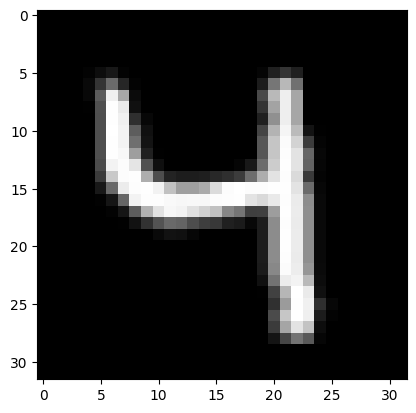

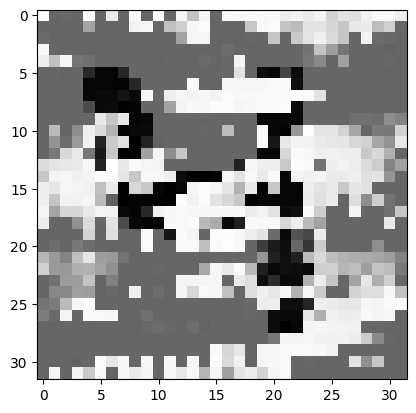

C:\Users\Anton\AppData\Local\Temp\ipykernel_14244\3668408836.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.argmax(F.log_softmax(out).detach()).item()


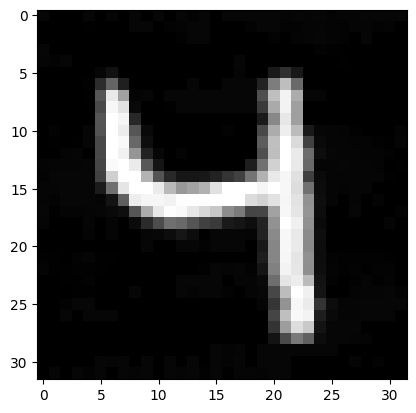

4






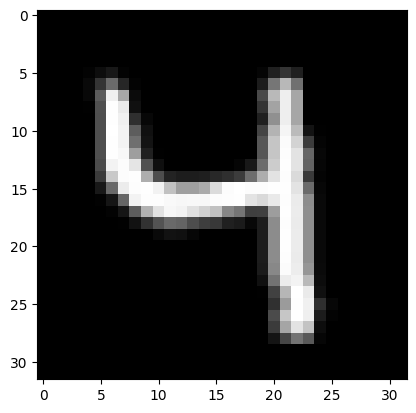

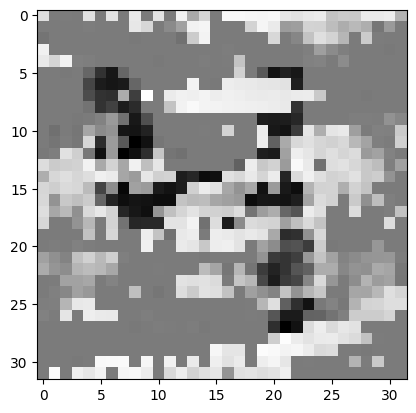

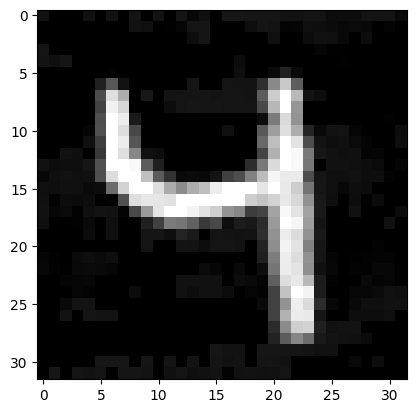

9






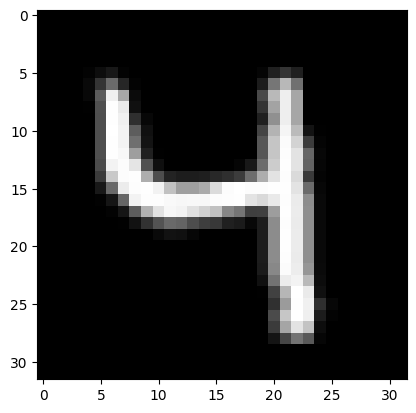

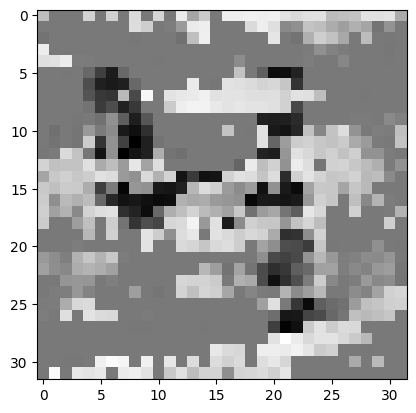

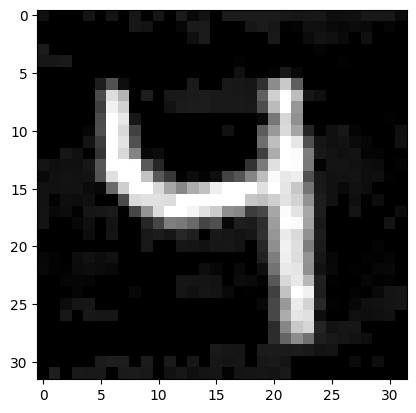

9






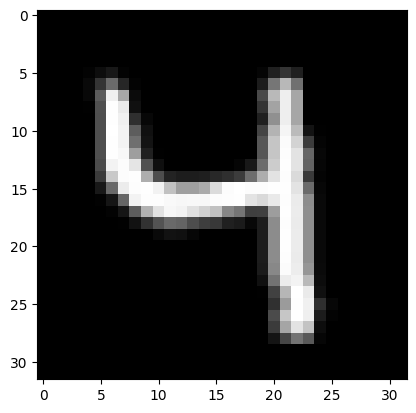

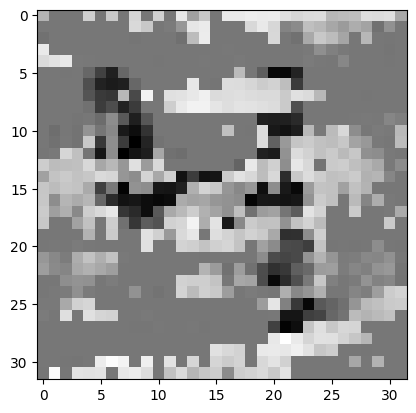

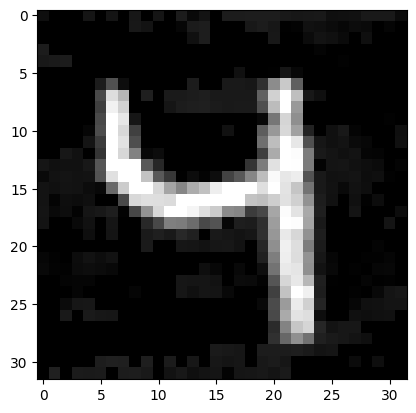

9






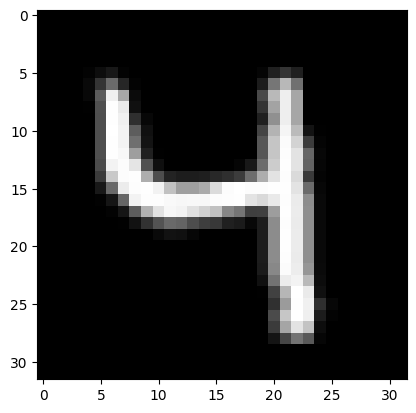

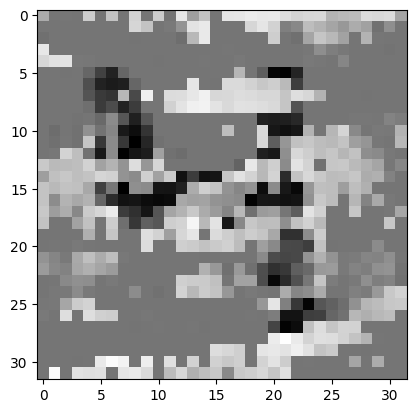

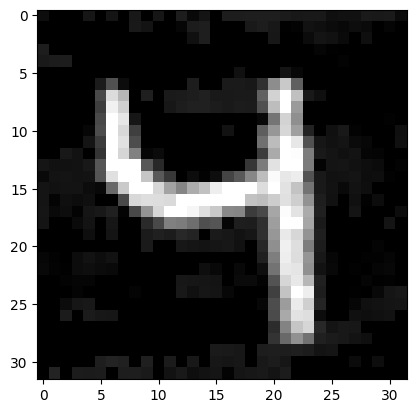

9






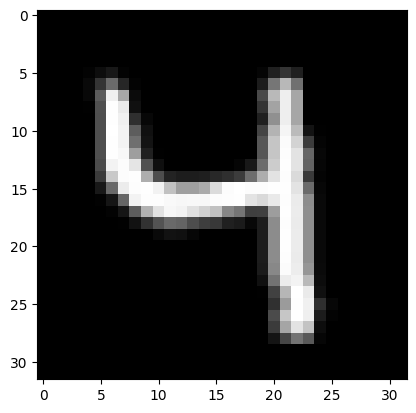

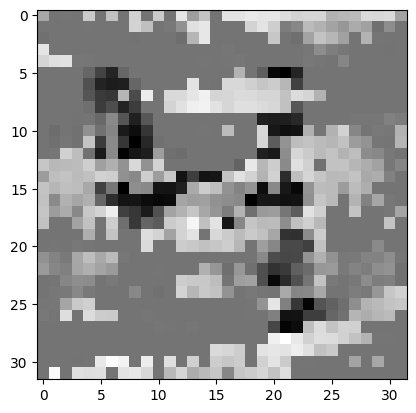

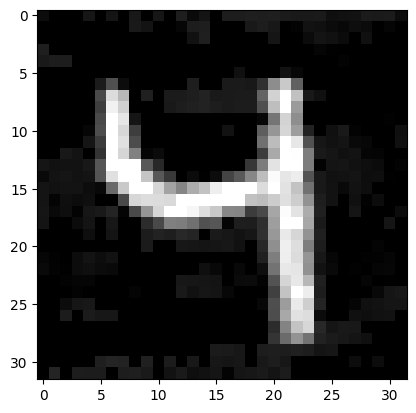

9






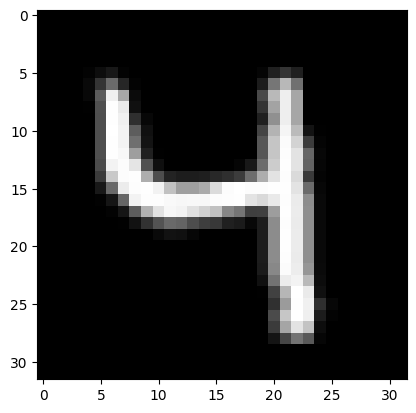

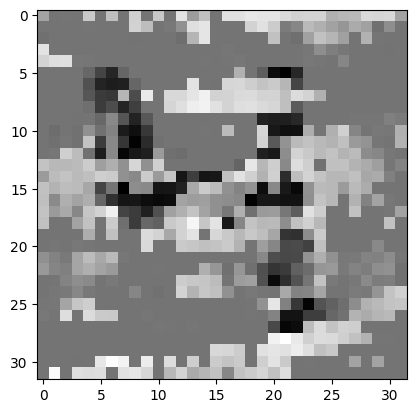

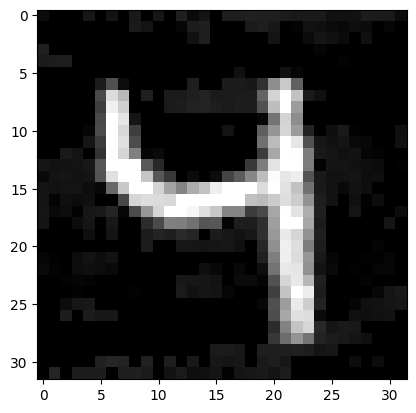

9






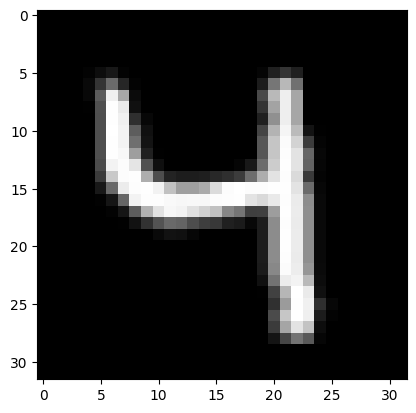

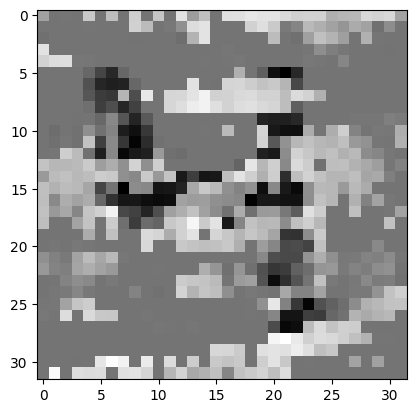

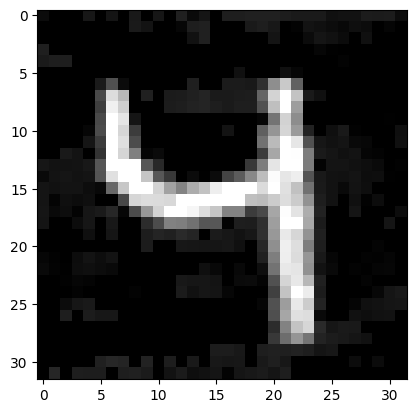

9






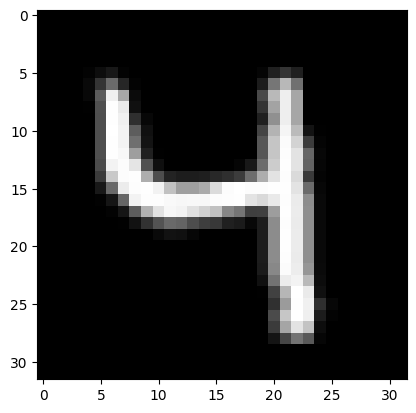

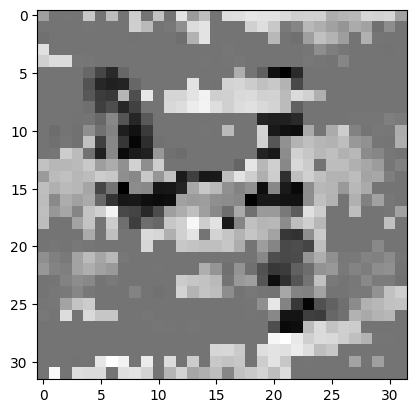

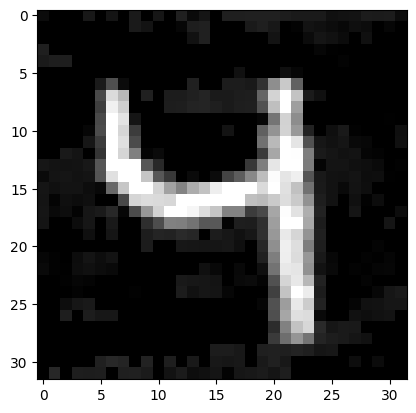

9






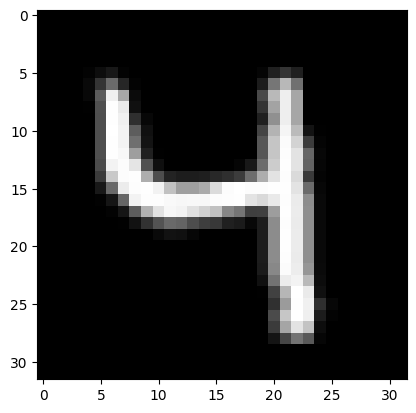

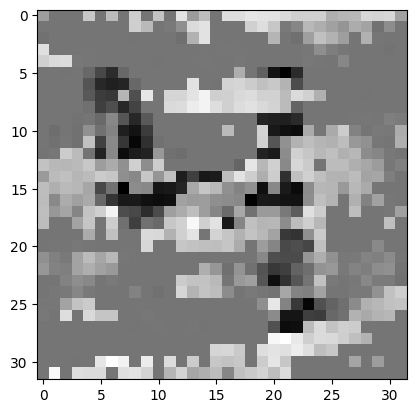

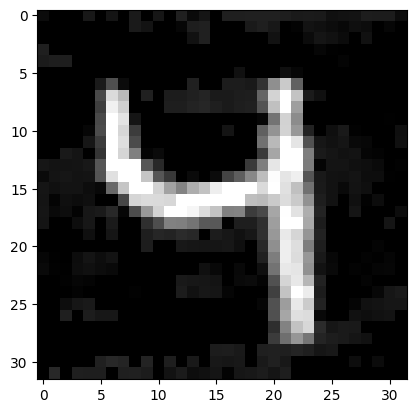

9






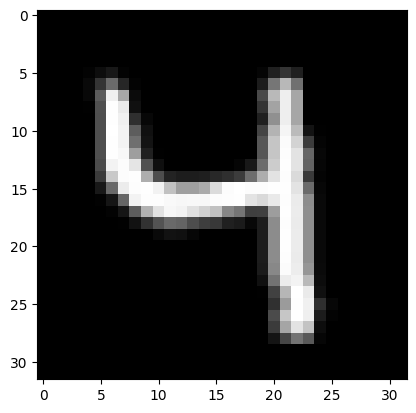

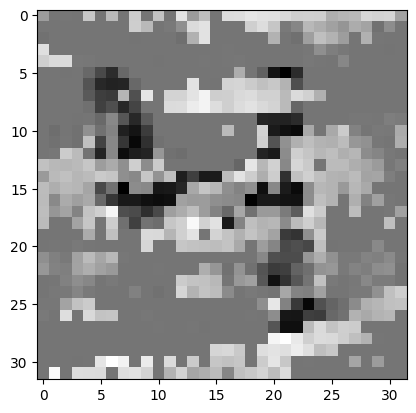

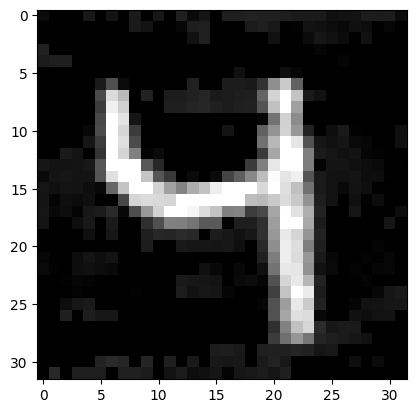

9






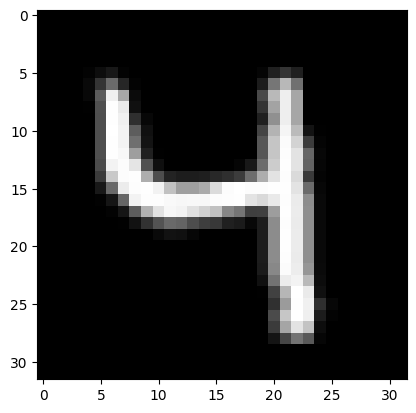

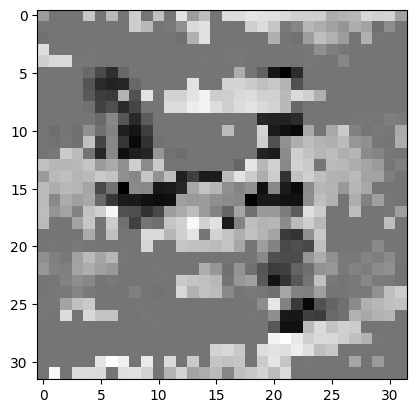

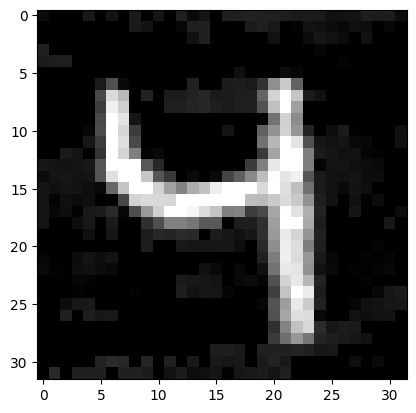

9






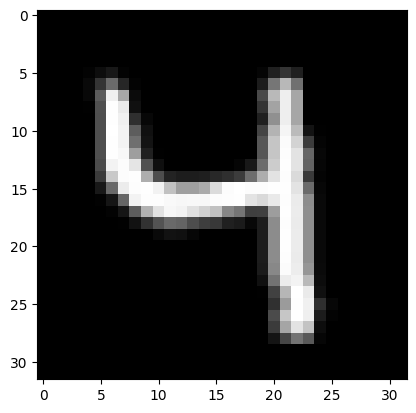

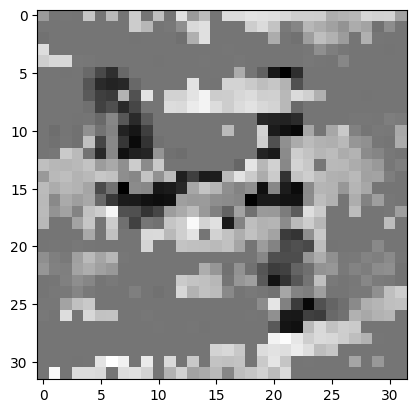

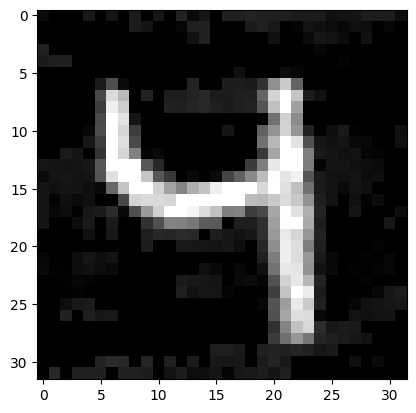

9






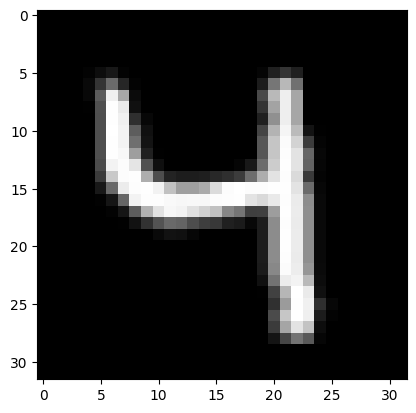

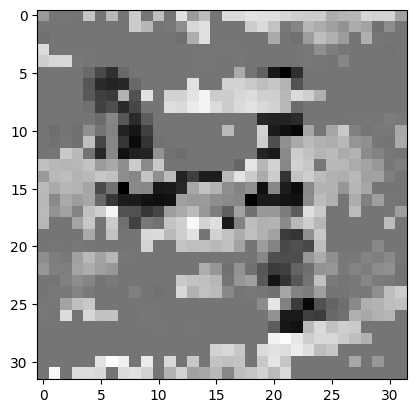

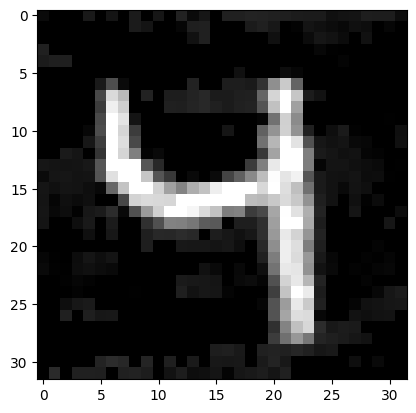

9






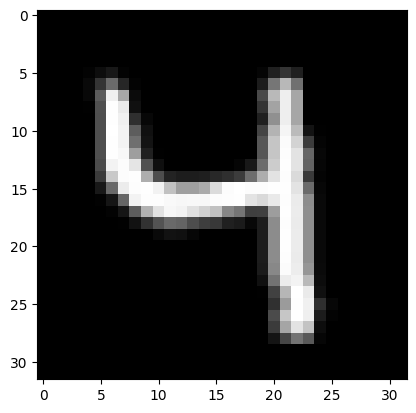

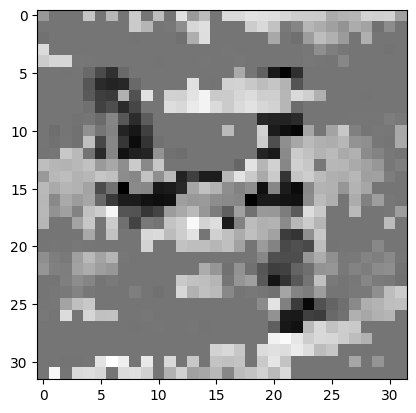

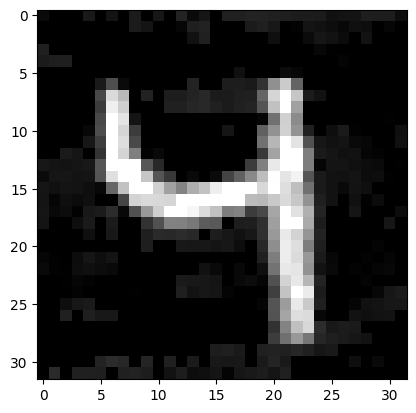

9






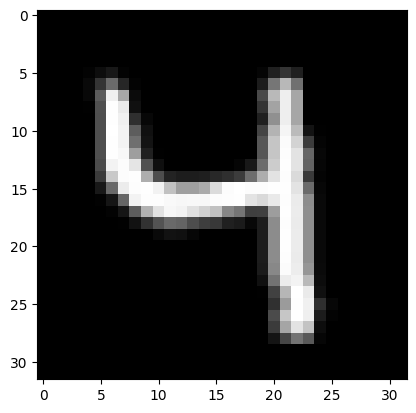

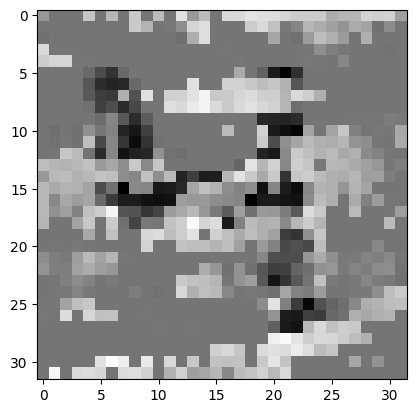

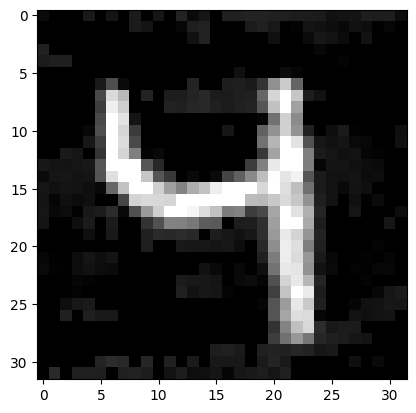

9






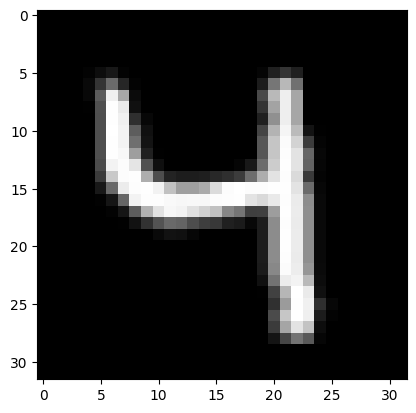

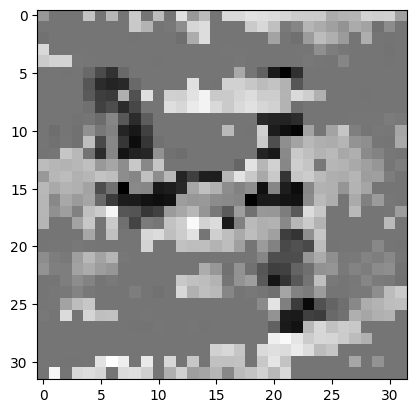

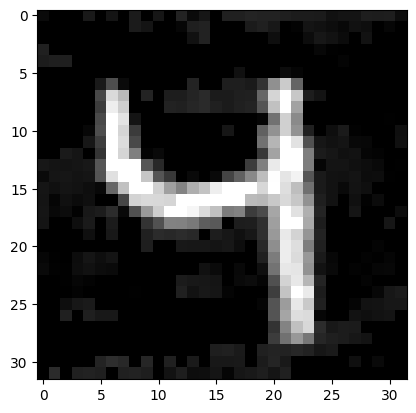

9






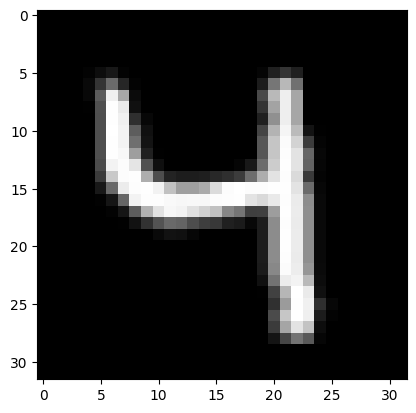

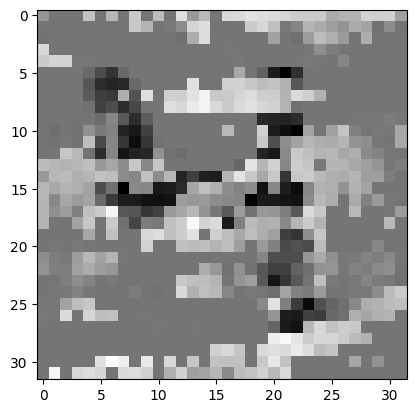

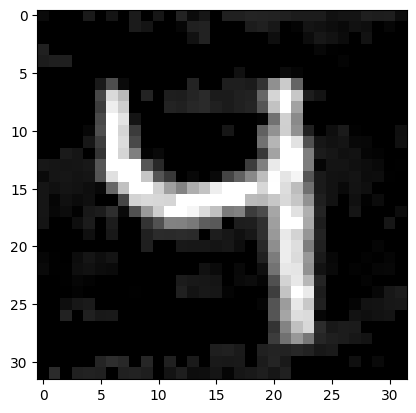

9






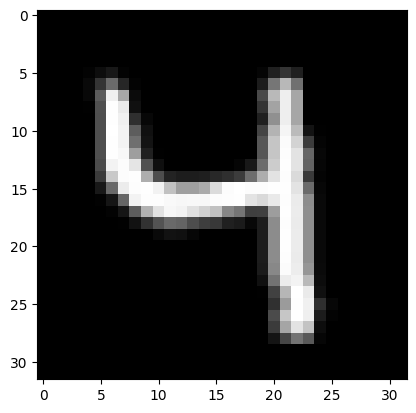

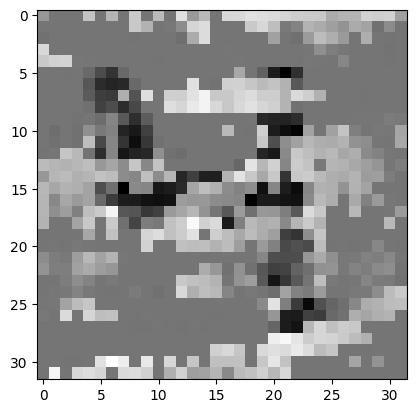

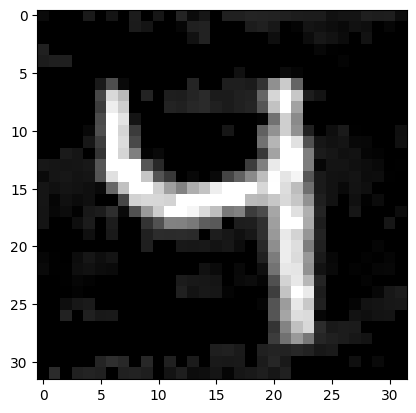

9






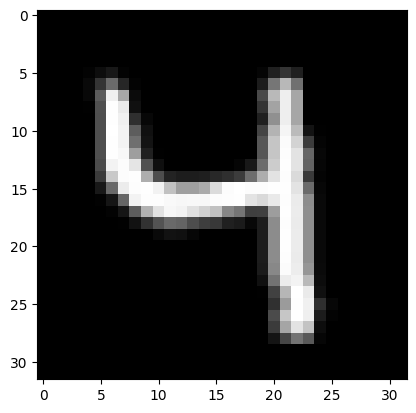

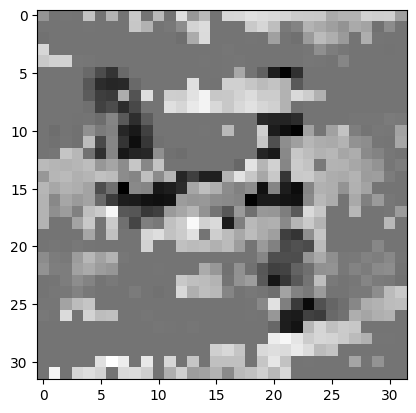

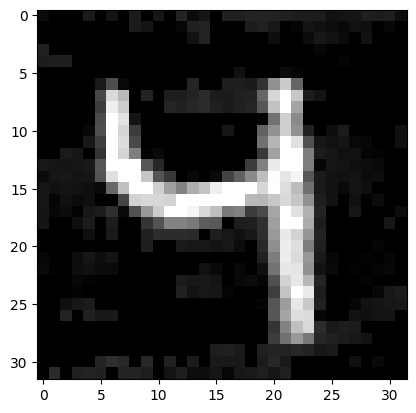

9






In [29]:


def plot_digit(data):
    data = data.view(32, 32)
    plt.imshow(data, cmap="gray")
    plt.show()

image, _ = next(it)
print(image.shape)
noise = torch.zeros_like(image)
noise.requires_grad = True

optimizer = optim.Adam([noise], lr=0.001)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    adv_image = torch.clamp(image + noise, 0, 1).to(device)
    out = trained_model(adv_image).to(device)
    loss = criterion(out, F.one_hot(torch.Tensor([9]).long(),num_classes=10).to(torch.float).to(device))
    #print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%50==25:
        plot_digit(image)
        plot_digit(noise.detach())
        prediction = torch.argmax(F.log_softmax(out).detach()).item()
        plot_digit(adv_image.cpu().detach())
        print(prediction)
        print("\n"*3)

torch.Size([1, 1, 32, 32])


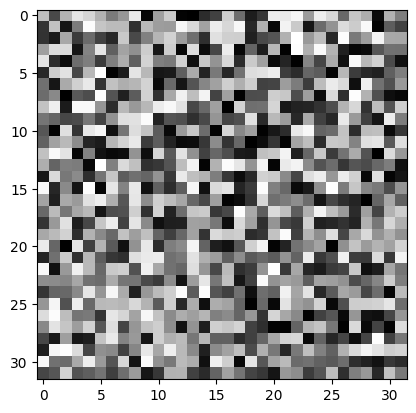

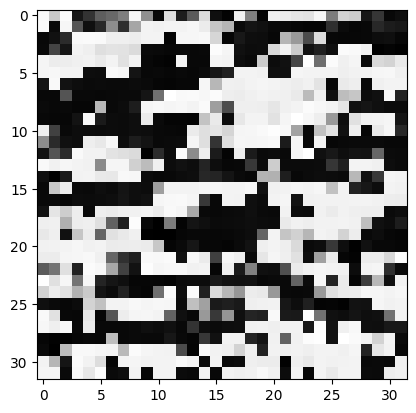

C:\Users\Anton\AppData\Local\Temp\ipykernel_14244\1423404698.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.argmax(F.log_softmax(out).detach()).item()


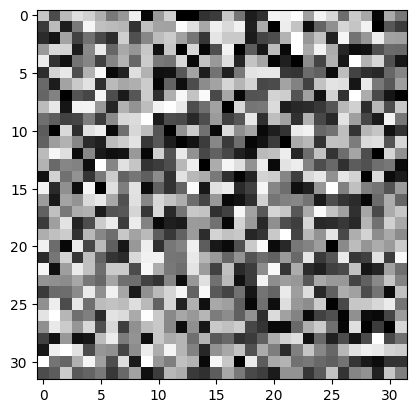

8






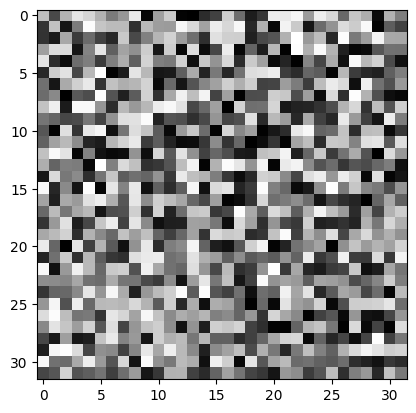

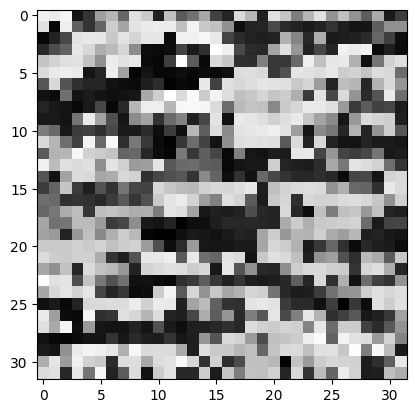

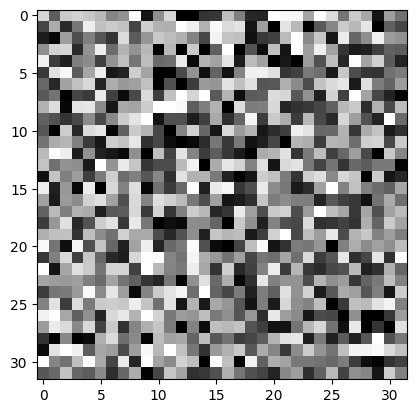

8






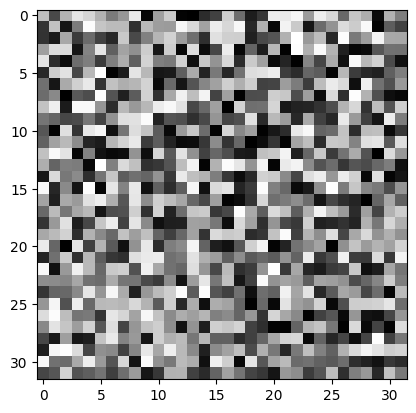

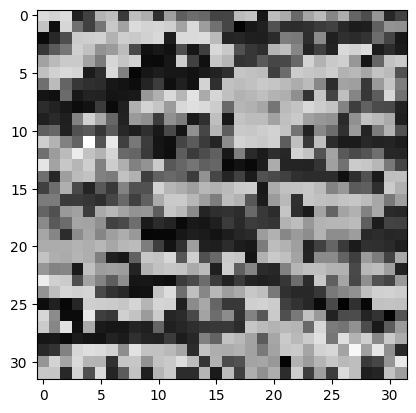

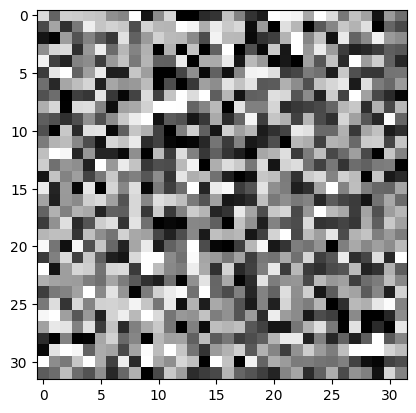

9






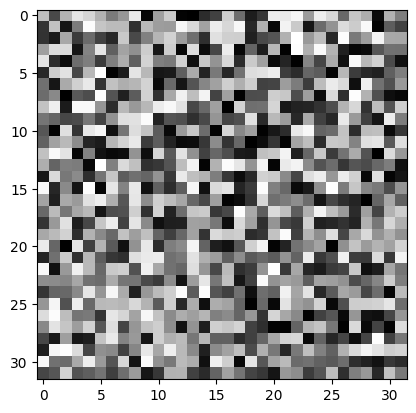

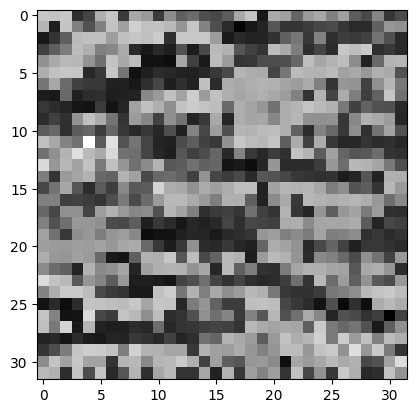

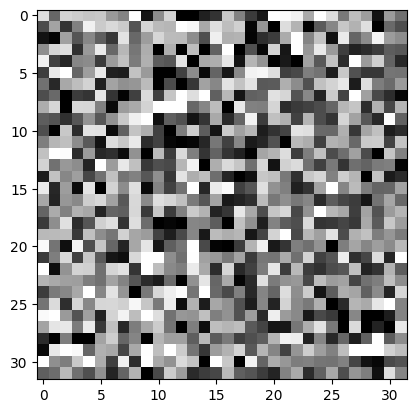

9






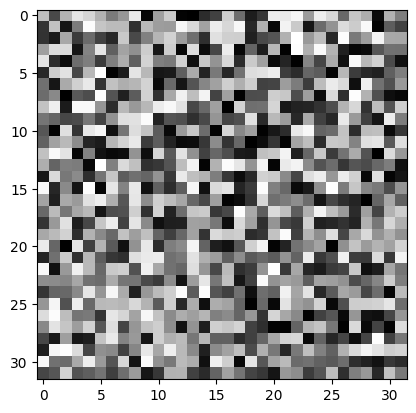

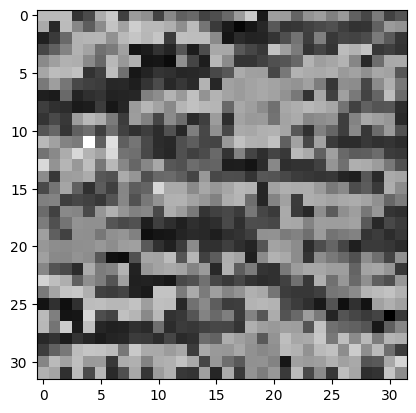

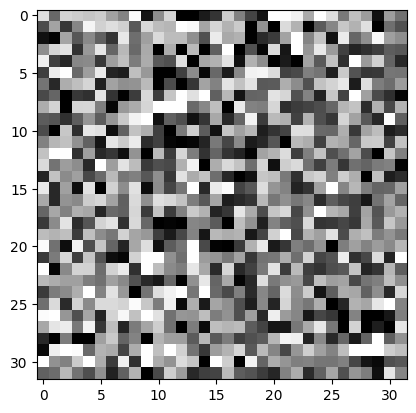

9






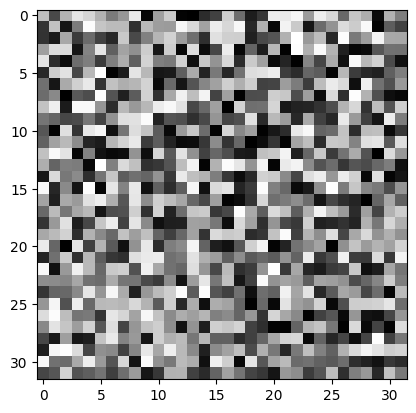

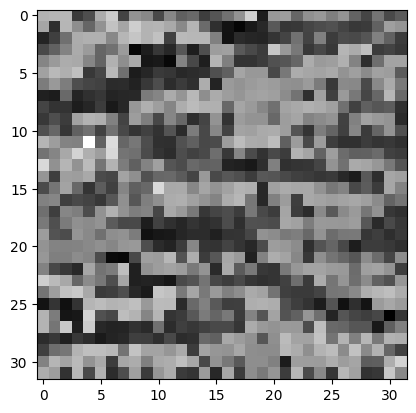

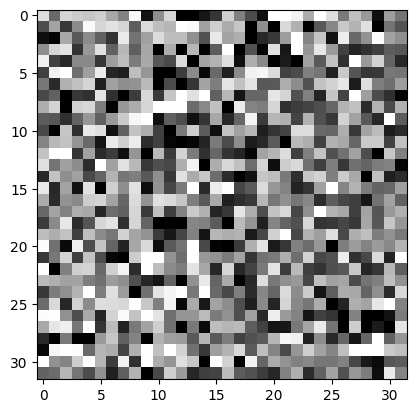

9






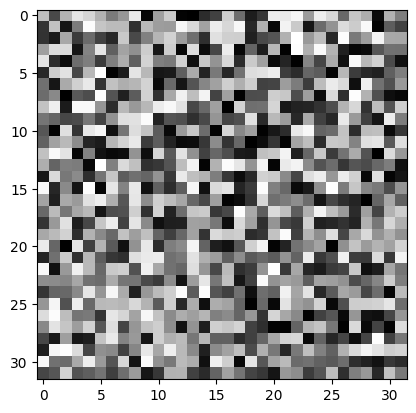

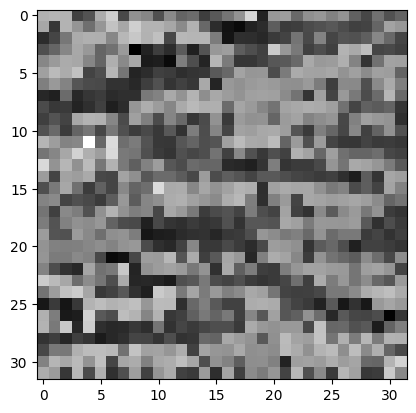

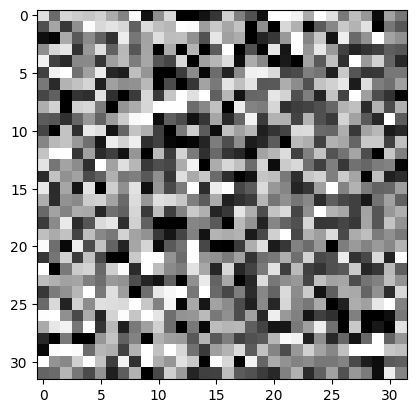

9






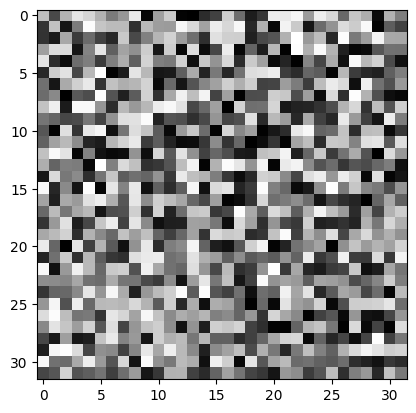

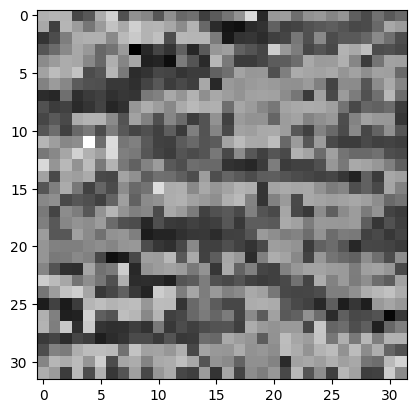

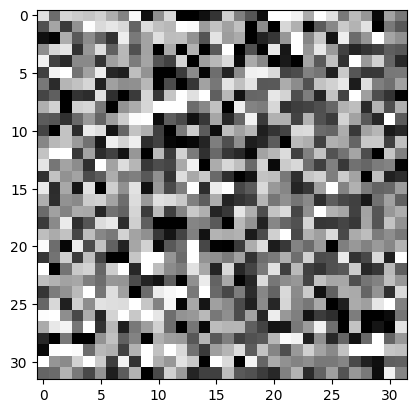

9






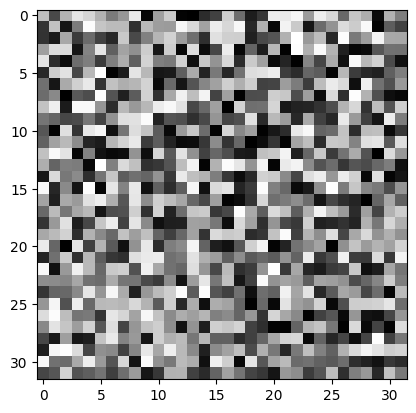

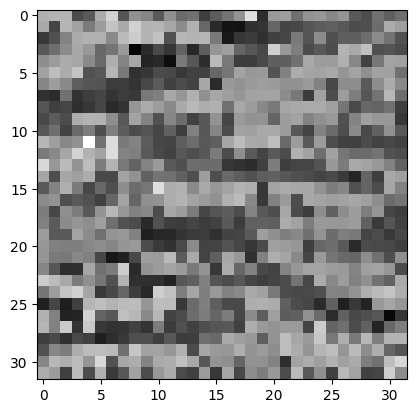

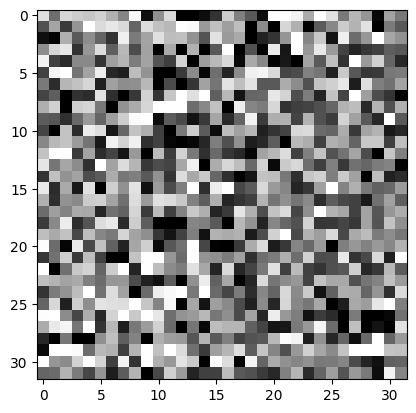

9






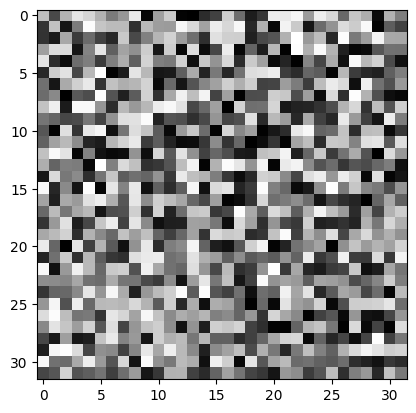

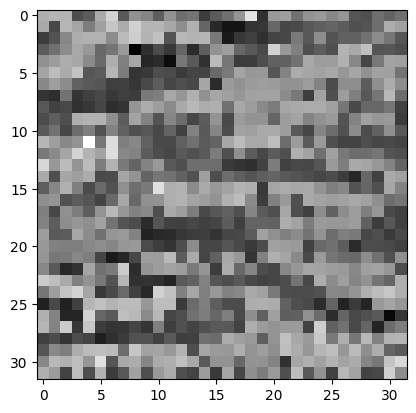

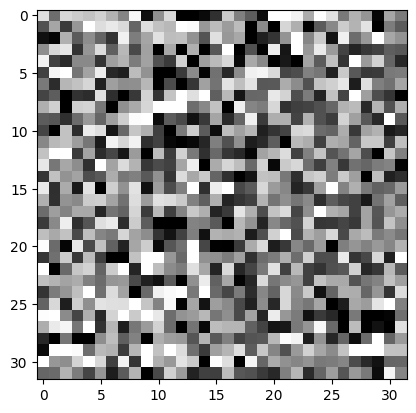

9






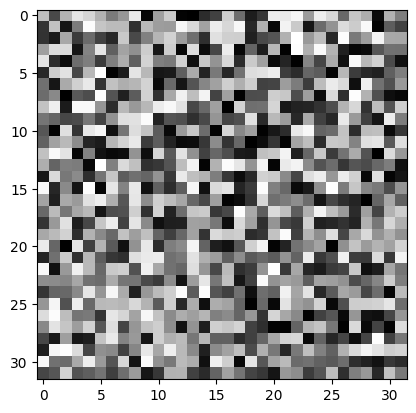

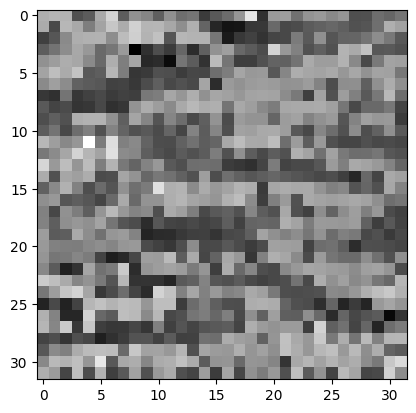

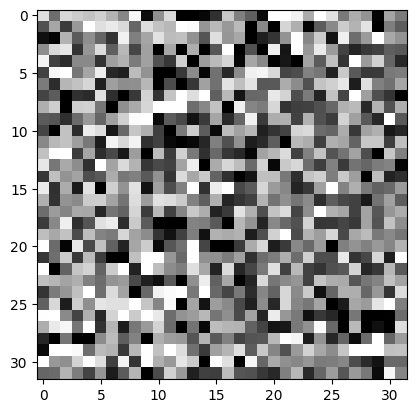

9






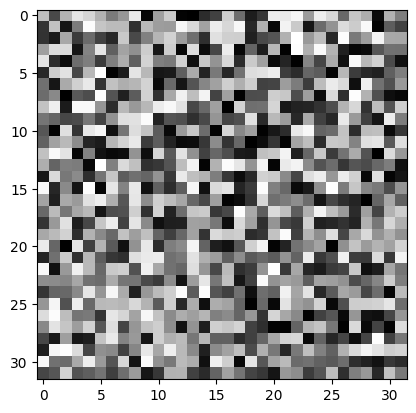

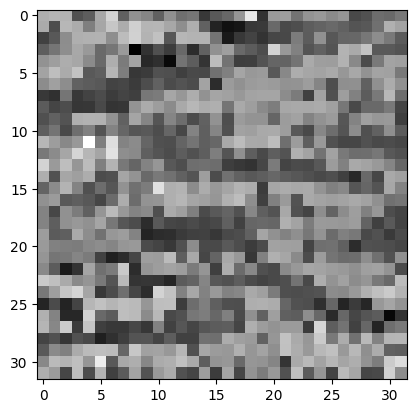

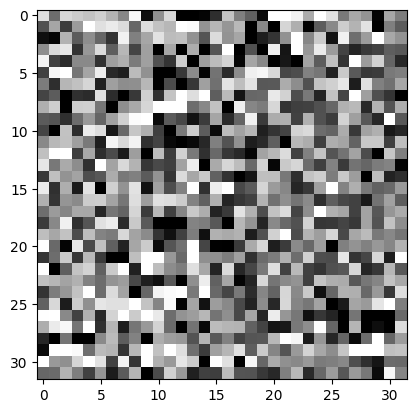

9






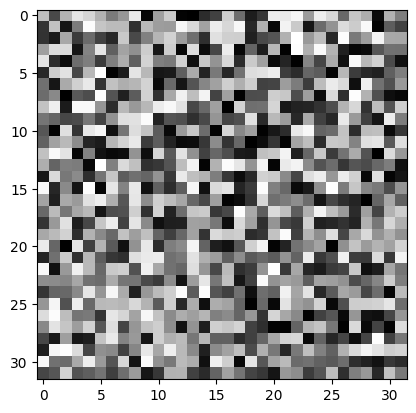

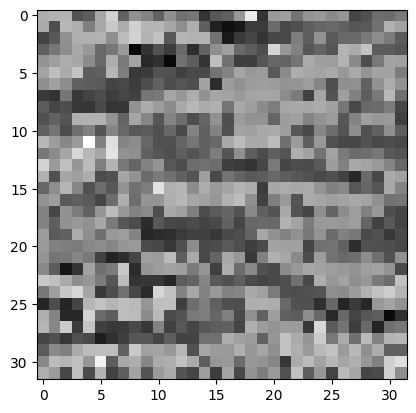

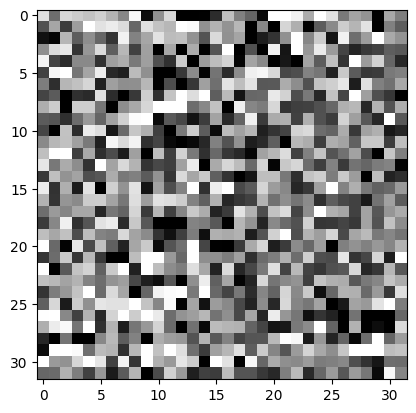

9






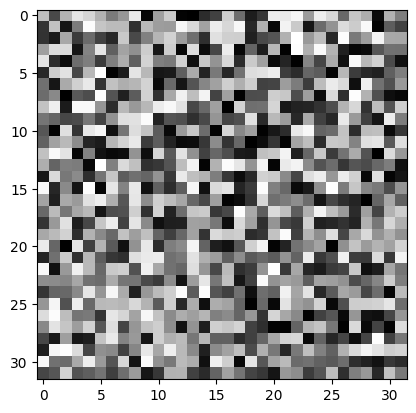

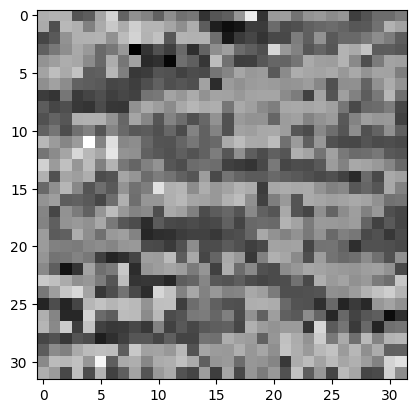

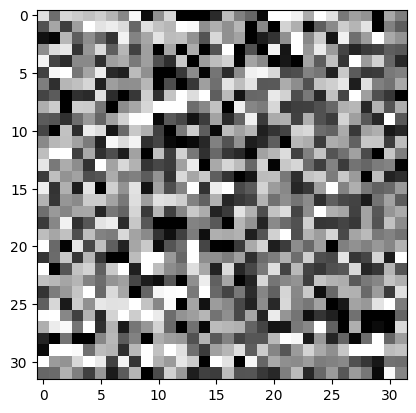

9






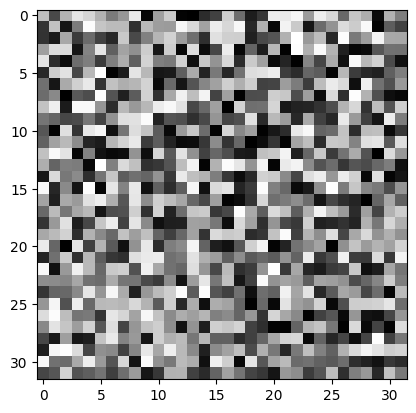

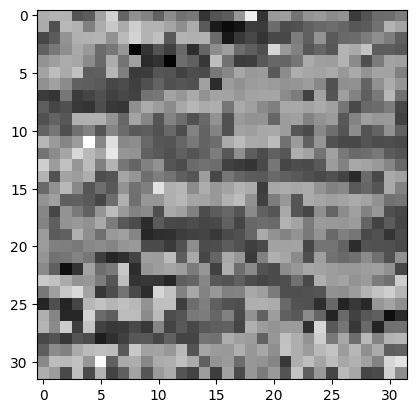

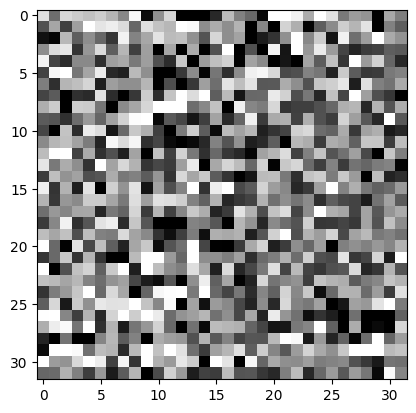

9






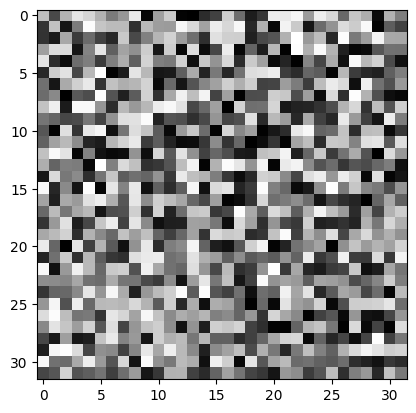

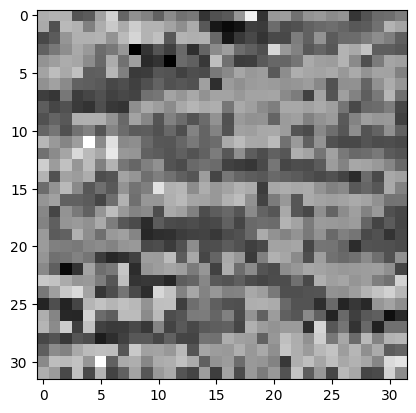

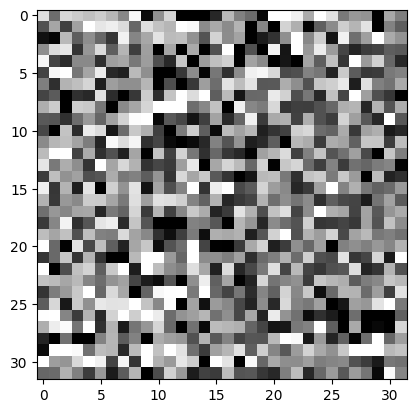

9






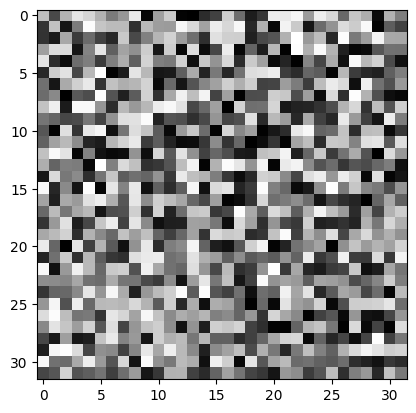

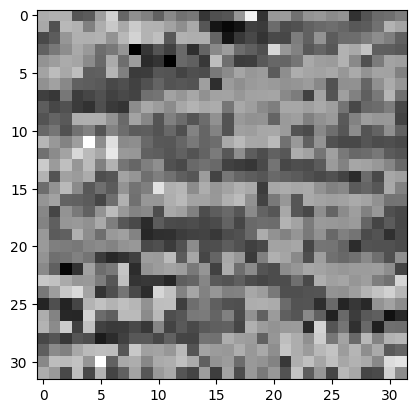

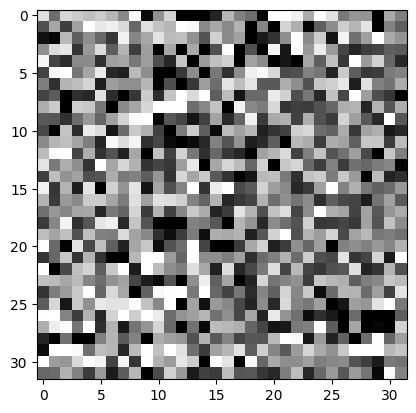

9






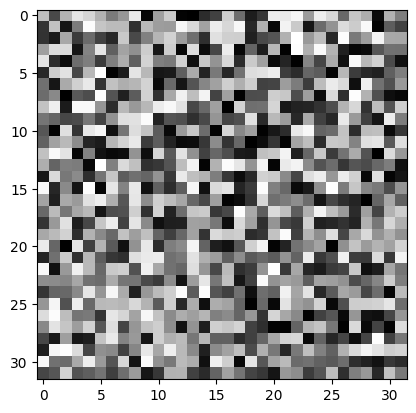

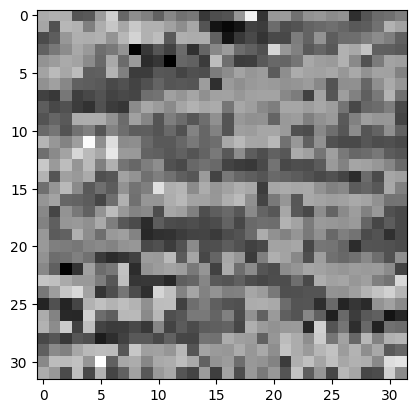

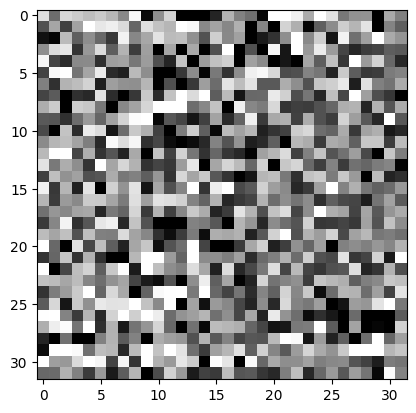

9






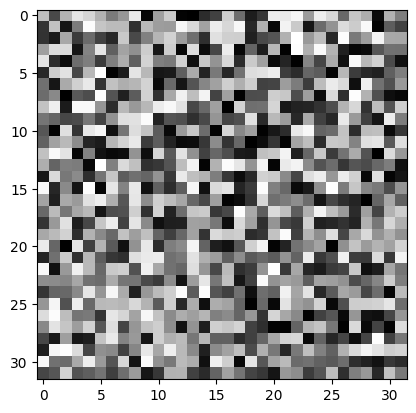

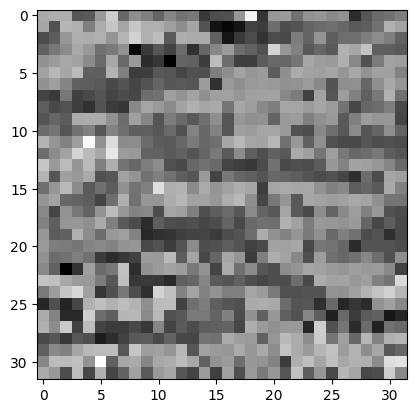

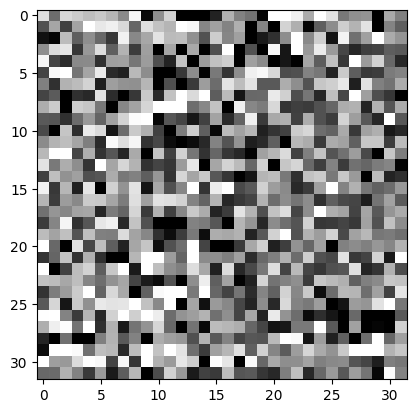

9






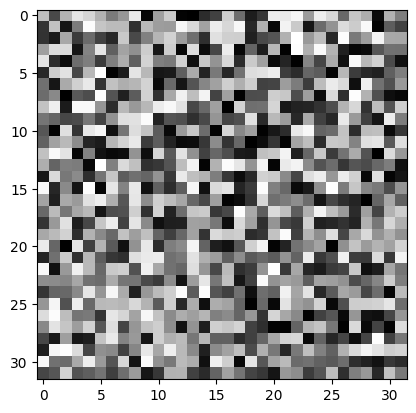

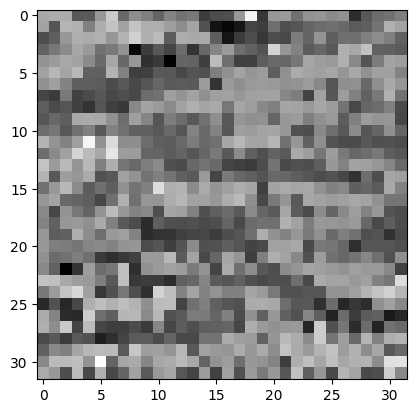

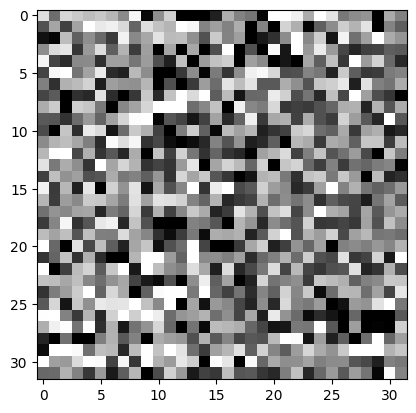

9






In [34]:
def plot_digit(data):
    data = data.view(32, 32)
    plt.imshow(data, cmap="gray")
    plt.show()

image = torch.rand(1, 1,32,32)
print(image.shape)
noise = torch.zeros_like(image)
noise.requires_grad = True

optimizer = optim.Adam([noise], lr=0.001)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    adv_image = torch.clamp(image + noise, 0, 1).to(device)
    out = trained_model(adv_image).to(device)
    loss = criterion(out, F.one_hot(torch.Tensor([9]).long(),num_classes=10).to(torch.float).to(device))
    #print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%50==25:
        plot_digit(image)
        plot_digit(noise.detach())
        prediction = torch.argmax(F.log_softmax(out).detach()).item()
        plot_digit(adv_image.cpu().detach())
        print(prediction)
        print("\n"*3)